In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 

from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import PIL
#import helper functions

torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(128)
torch.cuda.is_available()

True

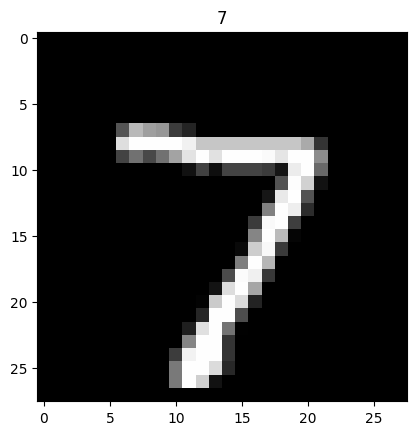

In [3]:
#Visualising data
# Download the dataset first
train_data = datasets.MNIST("~/data", train=True, download=True)
test_data = datasets.MNIST("~/data", train=False, download=True)

# custom_transform = transforms.Compose([ToTensor(),transforms.RandomResizedCrop(size=28, scale=(0.5, 1.0), ratio=(1.0, 1.0))]) # Model 2
# custom_transform = transforms.Compose([ToTensor(),transforms.RandomAffine(degrees=10, translate=(0.4,0.4), scale=(0.25, 1.25))]) #Model 3
custom_transform = transforms.Compose([ToTensor()]) #Model 3.1

train_loader = DataLoader(
        datasets.MNIST("./data", train=True, download=True, transform=custom_transform),
        batch_size=128,
        shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(
        datasets.MNIST("./data", train=False, download=True, transform=custom_transform),
        batch_size=128,
        shuffle=False, num_workers=4, pin_memory=True)
images, labels = next(iter(test_loader))
img, label = images[0].squeeze(), labels[0].item()
plt.title(label)
plt.imshow(img, cmap="gray")

TypeError: resized_crop() missing 3 required positional arguments: 'height', 'width', and 'size'

<Figure size 640x480 with 0 Axes>

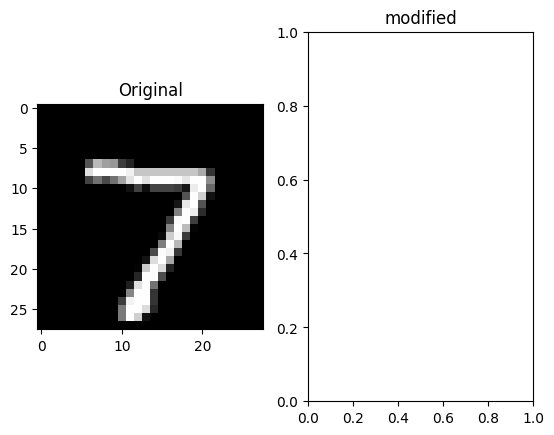

In [5]:
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].set_title("Original")
axarr[0].imshow(img, cmap="gray")

def crop_my_image(image: PIL.Image.Image) -> PIL.Image.Image:
    """Crop the images so only a specific region of interest is shown to my PyTorch model"""


    ct = transforms.Compose([ToTensor(), transforms.functional.resized_crop(28,(0.7,0.7), (1,1))]) #Model 3
    tensorr = transforms.Compose([ToTensor()]) #Model 3
    m = nn.Threshold(-1,0)
    output = m(ct(image).add(tensorr(image)))
    return torch.clamp(output, 0, 1)
    

custom_transform = transforms.Compose([transforms.Lambda(crop_my_image)]) #Model 3
axarr[1].set_title("modified")
axarr[1].imshow(custom_transform(img.numpy()).squeeze(), cmap="gray")


In [4]:
#! Unable to 
#Familier model, best 98.69% epoch 6
#nn.CrossEntropyLoss(),
#optim.Adam(params=model_0.parameters(), lr=0.001, weight_decay=0.001),

class digit_classifier(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier, self).__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2)#14/2
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2)#14/2

       
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, len(train_data.classes))
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    #! Don't use softmax, stabilty reason? 
    return x
model_0 = digit_classifier(20).to(device) #Only one input channel

In [27]:
class digit_classifier_1(nn.Module):
  def __init__(self, hidden=10):
    super(digit_classifier_1, self).__init__()

    self.block_1 = nn.Sequential(
        nn.BatchNorm2d(1),
        nn.Conv2d(in_channels=1, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),#28
        nn.LeakyReLU(),
        #Don't work with onnx?
        nn.MaxPool2d(kernel_size=2, stride=2),#14/2
    )
    self.block_2 = nn.Sequential(
        nn.BatchNorm2d(hidden),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        nn.Conv2d(hidden, hidden, kernel_size=3, stride=1, padding=1),#14
        nn.LeakyReLU(),
        #Don't work with onnx?
         nn.MaxPool2d(kernel_size=2, stride=2), #14/2

    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, hidden*7*7),
        nn.Linear(hidden*7*7, len(train_data.classes)),
    )
  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x =  self.output(x)
    return x
model_1 = digit_classifier_1(20).to(device)
net = nn.DataParallel(model_1)

In [6]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optim: torch.optim,
               device: torch.device,
               print_output:bool=True):
    model.train()
    train_loss, train_acc = 0, 0
    for (X, y) in dataloader :#tqdm inside enumrater
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        train_loss += loss # ?.item()

        optim.zero_grad()

        loss.backward()

        optim.step()

    train_acc /= len(dataloader)
    train_loss /= len(dataloader)

    if print_output: print(f"train: {train_loss}, {train_acc}%")  
    return [train_loss.item(), train_acc]

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device,
               print_output:bool=True):
    ##Testing
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch
            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
    
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    if print_output: print(f"test: {test_loss}, {test_acc}%")
    return test_acc



In [30]:
epochs = 6

model_1.to(device)
#? Scedchuler
for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n--------")
  train_step(model_1, train_loader,
           nn.CrossEntropyLoss(),
           optim.SGD(params=model_1.parameters(), lr=0.001),
           device)

  test_step(model_1, test_loader,
           nn.CrossEntropyLoss(),
           device)
        
        

Epoch 1
--------
train: 0.29632729291915894, 90.6039001421464%
test: 0.2621205151081085, 91.7128164556962%
Epoch 2
--------
train: 0.2834804654121399, 91.12251243781095%
test: 0.2623780071735382, 91.65348101265823%
Epoch 3
--------
train: 0.28929173946380615, 90.86709310589907%
test: 0.27639222145080566, 91.07990506329114%
Epoch 4
--------
train: 0.293608695268631, 90.75437544420754%
test: 0.2600635290145874, 91.4754746835443%
Epoch 5
--------
train: 0.2866230905056, 90.96370824449183%
test: 0.27844053506851196, 91.15901898734177%
Epoch 6
--------
train: 0.2897440791130066, 90.78324893390192%
test: 0.26295214891433716, 91.43591772151899%


{'0 - zero': -2.3077867, '1 - one': -2.1793072, '2 - two': -2.2452514, '3 - three': -2.264673, '4 - four': -2.369745, '5 - five': -2.3979537, '6 - six': -2.438275, '7 - seven': -2.1716192, '8 - eight': -2.364056, '9 - nine': -2.323978}


Text(0.5, 1.0, 'True: 7 - seven \n Prediction: 7 - seven')

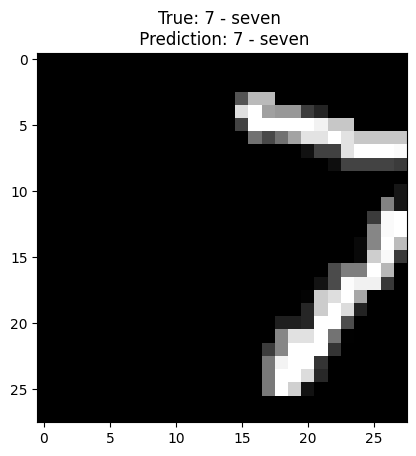

In [8]:
#Making some predictions
model_1.to(device="cpu")
model_1.eval()
with torch.inference_mode():
    y_logit = model_1(img.unsqueeze(1))
    # Get prediction probability (logit -> prediction probability)
    pred_prob = nn.LogSoftmax(dim=1)

    #print(pred_prob(y_logit/5).squeeze().numpy())
    #print(class_names)
    print(dict(zip(train_data.classes, pred_prob(y_logit).squeeze().numpy()))) #? Why /5

    # Get pred_prob off GPU for further calculations
    y_pred = y_logit.argmax(dim=1)
model_1.to(device=device)
plt.imshow(img.squeeze(), cmap="gray")
plt.title(f'True: {train_data.classes[label]} \n Prediction: {train_data.classes[y_pred]}')

In [9]:
x = torch.zeros(1,1,28,28)
model_1.eval()

torch.onnx.export(model_1,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model_3.onnx",   # where to save the model (can be a file or file-like object)
                  opset_version=9,          # the ONNX version to export the model to
                  verbose=True,        # store the trained parameter weights inside the model file
                  )


x.shape

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)